### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

### Create trading strategy using linear regression

In [2]:
class Regressionanalysis:

    # The constructor will be called during the object creation and the data feed for
    # the object is stored which could be used for further analysis
    def __init__(self, ticker, start, end, interval):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.interval = interval
        self.data = yf.download(self.ticker, start=self.start,
                                end=self.end, interval=self.interval)

# --------------------------------------------------------------------------------------------------------------------

    def linear_regression(self, independent='Open', dependent='Close'):

        # This function simulates simpnle linear regression fit using given dependent and independent variables and
        # provides summary for the same
        df = self.data
        x = df[independent]
        y = df[dependent]
        x = sm.add_constant(x)

        # Create regression model
        reg_model = sm.OLS(y, x).fit()

        # Generate model summary
        print(reg_model.summary())

        # Generate a component and component-plus-residual (CCPR) plot.
        fig = sm.graphics.plot_ccpr(reg_model, independent)
        fig.tight_layout(pad=1.0)

# ---------------------------------------------------------------------------------------------------------------------

    def rolling_reg(self, period=14):

        df = self.data
        df = df.dropna()
        window = period
        df['a'] = None
        df['b1'] = None

        # Calculate rolling fit by iterating each value
        for i in range(window, len(df)):
            temp = df.iloc[i-window:i, :]
            RollOLS = sm.OLS(temp.loc[:, 'Close'], sm.add_constant(
                temp.loc[:, ['Open']])).fit()
            df.iloc[i, df.columns.get_loc('a')] = RollOLS.params[0]
            df.iloc[i, df.columns.get_loc('b1')] = RollOLS.params[1]

        # The following line gives you predicted values in a row, given the prior row's estimated parameters
        df['predicted'] = df['a'].shift(1)+df['b1'].shift(1)*df['Open']

# --------------------------------------------------------------------------------------------------------------

        # Calculate profit or loss

        df['pnl'] = 0
        # The position is long profit = buy price (open) - sell price (close)
        df.loc[(df['predicted'] < df['Open']), 'pnl'] = df['Open']-df['Close']
        # The position is short the profit will be cover price(close) - Short price(open)
        df.loc[(df['predicted'] > df['Open']), 'pnl'] = df['Close']-df['Open']

        # Count profit making and loss making trades

        npt = df[df["pnl"] > 0].count()["pnl"]
        nlt = df[df["pnl"] < 0].count()["pnl"]

        # Calculate metrics like returns(%), max drawdown

        df['ret'] = 0

        df.loc[(df['predicted'] < df['Open']), 'ret'] = (
            df['Open']-df['Close'])/df['Open']

        df.loc[(df['predicted'] > df['Open']), 'ret'] = (
            df['Close']-df['Open'])/df['Open']
        daily_pct_c1 = df['ret']

        daily_pct_c1.reset_index(drop=True)

        # Drawdown and max drawdown

        window = int(252*6.5)
        rolling_max = df['ret'].rolling(window, min_periods=1).max()
        drawdown = df['ret']/rolling_max - 1.0

        # Print the results in a simulated tab
        fig, ax = plt.subplots(3, figsize=(10, 6), constrained_layout=True)
        ax[0].hist(daily_pct_c1, bins=50)
        ax[0].set(title='Retutns(%) Distribution')
        ax[1].set(title='Backtest Estimate')
        ax[1].text(0.5, 0.3, "NET pnl (POINTS) "+str(df["pnl"].sum()),
                   color='green', fontsize=12, ha='center')
        ax[1].text(0.5, 0.5, "Accuracy (%) "+str("%.5f" %
                                                 float((npt/(npt+nlt))*100)), color="green", fontsize=12, ha='center')
        ax[1].text(0.5, 0.7, "Total number of trades "+str(npt+nlt),
                   color='green', fontsize=12, ha='center')
        ax[2].plot(df.index, (drawdown), 'r')
        ax[2].set(title='Drawdown Curve')
        plt.show()

        return df

In [3]:
# Enter start and end date
start = '2020-1-20'
end = '2021-1-20'

# Create Regressionanalyis class
ra = Regressionanalysis('^NSEI', start, end, interval='60m')

[*********************100%***********************]  1 of 1 completed


### Analyse output

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.296e+05
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:00:40   Log-Likelihood:                -9724.4
No. Observations:                1731   AIC:                         1.945e+04
Df Residuals:                    1729   BIC:                         1.946e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.0819     11.766      2.047      0.0

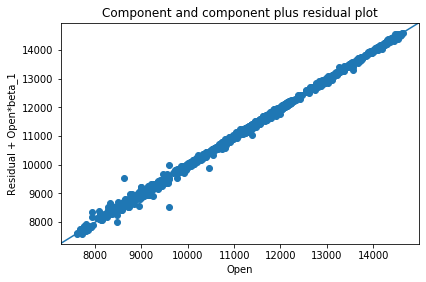

In [4]:
ra.linear_regression(independent='Open', dependent='Close')

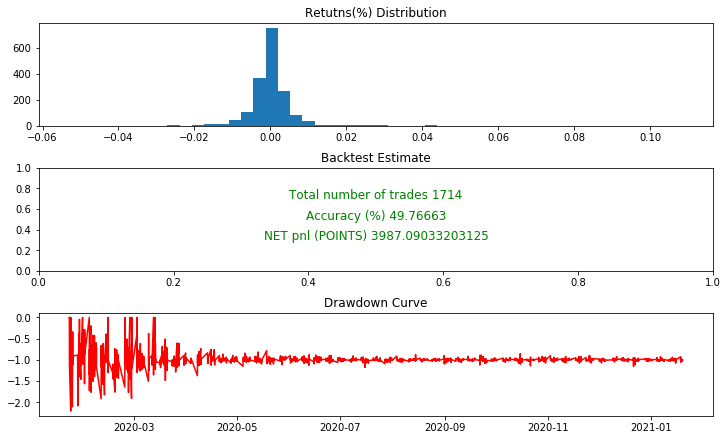

In [5]:
df = ra.rolling_reg(period=14)